# Курсовая работа  
## Классификация постов сообществ ВКонтакте по тематике железнодорожного и водного транспорта

В этом ноутбуке реализован полный код курсовой работы:  
от сбора постов из двух сообществ «ВКонтакте» до обучения модели,  
которая по тексту поста определяет, относится ли он к теме железнодорожного или водного транспорта.

## 1. Импорт библиотек и настройка окружения

На этом шаге подключаем все необходимые библиотеки:  
- для работы с данными (`pandas`, `numpy`);  
- для визуализации (`matplotlib`, `seaborn`);  
- для предобработки текста (`nltk`, `razdel`, `pymorphy2`, `emoji`);  
- для работы с VK API (`requests`, `vk_api`);  
- для обучения и оценки моделей (`scikit-learn`).

Также фиксируем параметры отображения графиков и загружаем список русских стоп-слов.

In [2]:
# Работа с файловой системой и регулярками
import os
import re
from collections import Counter

# Основные библиотеки для данных
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Работа с VK
import requests
import vk_api  # будем использовать официальную библиотеку

# Инструменты для обработки текста
import nltk
from nltk.corpus import stopwords
from razdel import tokenize
import pymorphy2
import emoji

# Модели и метрики из sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

/Users/vohmin.ae/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### 1.1. Загрузка стоп-слов и инициализация морфологического анализатора

Здесь скачиваем русские стоп-слова из `nltk`,  
создаём экземпляр `MorphAnalyzer` для лемматизации  
и задаём базовые настройки для графиков.

In [3]:
# Скачиваем стоп-слова NLTK (нужно выполнить один раз в этой среде)
nltk.download("stopwords")

# Загружаем список русских стоп-слов
russian_stopwords = set(stopwords.words("russian"))

# Инициализируем морфологический анализатор
morph = pymorphy2.MorphAnalyzer()

# Настройки графиков по умолчанию (чтобы потом не вспоминать)
plt.rcParams["figure.figsize"] = (10, 5)
sns.set(style="whitegrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vohmin.ae/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.2. Пример лемматизации

Коротко проверяем, что связка `razdel` + `pymorphy2` работает,  
и видим, как исходное предложение разбивается на токены  
и приводится к начальным формам.

In [4]:
test_text = "Поезд прибыл на станцию вовремя 🚂"
print("Оригинальный текст:", test_text)

# Пример токенизации
tokens = [t.text for t in tokenize(test_text.lower())]
print("Токены:", tokens)

# Пример лемматизации первого осмысленного слова
for token in tokens:
    if token.isalpha():
        lemma = morph.parse(token)[0].normal_form
        print(f"Слово: {token} -> лемма: {lemma}")
        break

Оригинальный текст: Поезд прибыл на станцию вовремя 🚂
Токены: ['поезд', 'прибыл', 'на', 'станцию', 'вовремя', '🚂']
Слово: поезд -> лемма: поезд


## 2. Сбор данных из ВКонтакте

### 2.1. Загрузка токена и настройка параметров VK API

Токен доступа к VK API хранится в переменной `token`  
Здесь мы читаем токен, задаём версию API и идентификаторы двух сообществ:  
железнодорожного (*rail*) и водного (*water*).

In [5]:
# Вставьте сюда свой access_token, полученный из адресной строки!
token='vk1.a.ZvdIna4ZdKd6es-ktjDQq7g7myLiumsQvfFJaqqkvKX9OQQuq2WljWVPHRZAOEC8q6ctPLROXdn86XKO3y-17ZdYOpCQoJxquHM4cgykmRo88b_tUJRWBUVixFm3CYy_F_sif3pLl6xZc1uoM-exOnn377Kw6lANK2jTVKMSyeyZ5FO3pCBSeA9QLpgVTzXQggZ1alnFWjD5TCAR7OWyAQ'

In [6]:
# Версия VK API
VK_API_VERSION = "5.199"

# Примеры ID групп (отрицательные числа — это сообщества)
# GROUP_ID_RAIL — группа про железные дороги
# GROUP_ID_WATER — группа про водный транспорт

GROUP_ID_RAIL = 'rzd_official'      # пример из методички, можешь заменить на свою ж/д-группу
GROUP_ID_WATER = 'fleet_history'    # временное значение, сюда поставь id своей "водной" группы


### 2.2. Функция для выгрузки постов методом `wall.get`

Определяем функцию `get_wall_posts`, которая постранично запрашивает  
посты со стены сообщества через метод `wall.get` и собирает их  
в единый `DataFrame`. Для каждого поста сохраняем текст, дату,  
а также базовые счётчики (лайки, репосты, комментарии, просмотры).

In [7]:
VK_API_URL = "https://api.vk.com/method/wall.get"


def get_wall_posts(
    owner_id: int,
    token: str,
    max_posts: int = 1000,
    chunk_size: int = 100,
):
    """
    Скачивает посты со стены сообщества VK и возвращает DataFrame.

    owner_id: отрицательный ID сообщества (например, -38981315)
    token: access_token VK
    max_posts: максимальное количество постов, которые хотим получить
    chunk_size: сколько постов запрашиваем за один запрос (максимум 100)
    """
    all_posts = []
    offset = 0

    while offset < max_posts:
        params = {
            "access_token": token,
            "owner_id": owner_id,
            "count": chunk_size,
            "offset": offset,
            "v": VK_API_VERSION,
            "filter": "owner",  # только посты от имени сообщества
        }

        response = requests.get(VK_API_URL, params=params)
        data = response.json()

        if "error" in data:
            print("VK API error:", data["error"])
            break

        items = data["response"]["items"]
        if not items:
            # посты закончились
            break

        for item in items:
            text = item.get("text", "")
            if not text.strip():
                # пропускаем совсем пустые тексты
                continue

            post_info = {
                "post_id": item.get("id"),
                "date": pd.to_datetime(item.get("date"), unit="s"),
                "owner_id": item.get("owner_id"),
                "text": text,
                "likes": item.get("likes", {}).get("count", 0),
                "reposts": item.get("reposts", {}).get("count", 0),
                "comments": item.get("comments", {}).get("count", 0),
                "views": item.get("views", {}).get("count", 0),
            }
            all_posts.append(post_info)

        offset += chunk_size

        if len(all_posts) >= max_posts:
            break

    df_posts = pd.DataFrame(all_posts)
    return df_posts

### 2.3. Выгрузка постов из двух сообществ

Здесь выгружаем несколько сотен постов из каждой группы:  
- железнодорожной (*rail*),  
- водного транспорта (*water*).  

После этого проверяем размер выборок и смотрим первые несколько строк.

In [8]:
df_rail_raw = get_wall_posts(GROUP_ID_RAIL, token, max_posts=500)
df_water_raw = get_wall_posts(GROUP_ID_WATER, token, max_posts=500)

print("Ж/д группа — постов:", len(df_rail_raw))
print("Водный транспорт — постов:", len(df_water_raw))

df_rail_raw.head()

Ж/д группа — постов: 335
Водный транспорт — постов: 498


,post_id,date,owner_id,text,likes,reposts,comments,views
0,391316,2025-12-08 09:30:22,-38981315,"В Амурской области есть станция, которую уважи...",66,5,13,4933
1,391008,2025-12-05 09:30:53,-38981315,"Поезд, который везёт к приятным сюрпризам!🥳 Эт...",137,74,107,13237
2,390810,2025-12-04 09:30:03,-38981315,В тепло через снега: двухэтажный поезд Москва ...,730,56,97,30808
3,390673,2025-12-03 09:30:00,-38981315,"На прошедшей недавно выставке-форуме ""Транспор...",465,114,239,52634
4,390586,2025-12-02 15:00:57,-38981315,В Москве на Казанском вокзале открылся новый б...,346,77,93,78328


In [9]:
df_water_raw.head()

,post_id,date,owner_id,text,likes,reposts,comments,views
0,36627,2015-06-20 17:30:00,-2169946,"Работы художника Atsushi Yamashita на тему ""Ру...",3515,636,326,0
1,348572,2025-12-08 16:00:00,-2169946,Эскортный авианосец Сэнгамон\n#Авианосцы@fleet...,21,0,1,515
2,348568,2025-12-08 15:00:01,-2169946,Эсминец МакКи в Мар Айленде 28 декабря 1944г\n...,22,0,1,1051
3,348567,2025-12-08 14:30:00,-2169946,"Линкор Теннесси в Сиднее, 1925г\n#Линкоры@flee...",31,0,0,872
4,348536,2025-12-08 10:11:17,-2169946,Бронепалубный крейсер Дрезден был единственным...,68,2,1,1286


## 3. Формирование корпуса и первичная фильтрация

На этом шаге формируем единый датасет:

- добавляем метки классов (`group` и `target`) для каждого сообщества;
- объединяем посты в общий `DataFrame`;
- удаляем пустые тексты и слишком короткие сообщения;
- убираем дубликаты.

В результате получаем корпус из уникальных постов двух тематик.

In [10]:
# Копии сырых датафреймов, чтобы не портить исходники
df_rail = df_rail_raw.copy()
df_water = df_water_raw.copy()

# Человеческая метка класса
df_rail["group"] = "rail"      # железные дороги
df_water["group"] = "water"    # водный транспорт

# Числовая метка (для моделей)
label_mapping = {"rail": 0, "water": 1}
df_rail["target"] = df_rail["group"].map(label_mapping)
df_water["target"] = df_water["group"].map(label_mapping)

# Оставим только нужные на данном этапе поля
cols_to_keep = ["post_id", "date", "text", "likes", "reposts", "comments", "views", "group", "target"]
df_rail = df_rail[cols_to_keep]
df_water = df_water[cols_to_keep]

df = pd.concat([df_rail, df_water], ignore_index=True)

print("Общий датасет:", df.shape)
print(df["group"].value_counts())
df.head()

Общий датасет: (833, 9)
group
water    498
rail     335
Name: count, dtype: int64


,post_id,date,text,likes,reposts,comments,views,group,target
0,391316,2025-12-08 09:30:22,"В Амурской области есть станция, которую уважи...",66,5,13,4933,rail,0
1,391008,2025-12-05 09:30:53,"Поезд, который везёт к приятным сюрпризам!🥳 Эт...",137,74,107,13237,rail,0
2,390810,2025-12-04 09:30:03,В тепло через снега: двухэтажный поезд Москва ...,730,56,97,30808,rail,0
3,390673,2025-12-03 09:30:00,"На прошедшей недавно выставке-форуме ""Транспор...",465,114,239,52634,rail,0
4,390586,2025-12-02 15:00:57,В Москве на Казанском вокзале открылся новый б...,346,77,93,78328,rail,0


In [11]:
# Приводим тексты к строковому типу
df["text"] = df["text"].astype(str)

# Удаляем строки, где текст только из пробелов
df["text_stripped"] = df["text"].str.strip()
df = df[df["text_stripped"] != ""].copy()

# Добавим длину текста в символах
df["text_len"] = df["text_stripped"].str.len()

# Можно отфильтровать совсем короткие посты (например, менее 20 символов)
min_len = 20
df = df[df["text_len"] >= min_len].copy()

# Убираем дубликаты по тексту
df = df.drop_duplicates(subset="text_stripped").reset_index(drop=True)

print("После фильтрации:", df.shape)
print(df["group"].value_counts())
df.head()

После фильтрации: (829, 11)
group
water    495
rail     334
Name: count, dtype: int64


,post_id,date,text,likes,reposts,comments,views,group,target,text_stripped,text_len
0,391316,2025-12-08 09:30:22,"В Амурской области есть станция, которую уважи...",66,5,13,4933,rail,0,"В Амурской области есть станция, которую уважи...",79
1,391008,2025-12-05 09:30:53,"Поезд, который везёт к приятным сюрпризам!🥳 Эт...",137,74,107,13237,rail,0,"Поезд, который везёт к приятным сюрпризам!🥳 Эт...",723
2,390810,2025-12-04 09:30:03,В тепло через снега: двухэтажный поезд Москва ...,730,56,97,30808,rail,0,В тепло через снега: двухэтажный поезд Москва ...,98
3,390673,2025-12-03 09:30:00,"На прошедшей недавно выставке-форуме ""Транспор...",465,114,239,52634,rail,0,"На прошедшей недавно выставке-форуме ""Транспор...",128
4,390586,2025-12-02 15:00:57,В Москве на Казанском вокзале открылся новый б...,346,77,93,78328,rail,0,В Москве на Казанском вокзале открылся новый б...,792


## 4. Предобработка текстов

### 4.1. Базовая очистка (`clean_text`)

Очищаем тексты от технического шума:

- приводим к нижнему регистру;
- удаляем ссылки и упоминания;
- убираем HTML-сущности;
- переводим эмодзи в текст и вычищаем лишние символы;
- сжимаем повторяющиеся пробелы.

Результат сохраняем в колонку `text_clean`.

In [12]:
# Регулярки заранее компилируем для скорости
url_pattern = re.compile(r"https?://\S+|www\.\S+")
mention_pattern = re.compile(r"\[club\d+\|.*?]")  # формат упоминаний VK вида [club123|Текст]
html_pattern = re.compile(r"&[a-zA-Z]+;")        # html-сущности типа &quot; &amp;


def clean_text(text: str) -> str:
    """
    Базовая очистка текста:
    - приведение к нижнему регистру
    - удаление ссылок, html-сущностей, упоминаний
    - замена эмодзи на текстовое описание
    - удаление лишних символов и пробелов
    """
    if not isinstance(text, str):
        text = str(text)

    # приводим к нижнему регистру
    text = text.lower()

    # удаляем ссылки
    text = url_pattern.sub(" ", text)

    # удаляем упоминания групп/пользователей в формате VK
    text = mention_pattern.sub(" ", text)

    # убираем html-сущности
    text = html_pattern.sub(" ", text)

    # заменяем эмодзи на текст (например, "🚂" -> ":locomotive:")
    text = emoji.demojize(text)

    # удаляем все символы, кроме букв, цифр и пробелов
    # если хочешь оставить цифры — убери "0-9" из шаблона
    text = re.sub(r"[^а-яa-z0-9\s:]", " ", text)

    # сжимаем повторяющиеся двоеточия в описаниях эмодзи
    text = re.sub(r":\s+", ":", text)

    # заменяем несколько пробелов на один
    text = re.sub(r"\s+", " ", text).strip()

    return text

df["text_clean"] = df["text_stripped"].apply(clean_text)

print("Пример исходного текста:")
print(df["text_stripped"].iloc[0])
print("\nПосле clean_text:")
print(df["text_clean"].iloc[0])

Пример исходного текста:
В Амурской области есть станция, которую уважительно называют по имени-отчеству

После clean_text:
в амурской области есть станция которую уважительно называют по имени отчеству


### 4.2. Лемматизация и удаление стоп-слов (`normalize_text`)

На этом этапе выполняем нормализацию:

- токенизируем текст с помощью `razdel`;
- приводим слова к начальной форме через `pymorphy2`;
- удаляем стоп-слова и слишком короткие токены.

Нормализованный текст (последовательность лемм)  
сохраняется в колонку `text_norm`.

In [13]:
def normalize_text(text: str) -> str:
    """
    Нормализация текста:
    - токенизация
    - лемматизация слов
    - удаление стоп-слов и слишком коротких токенов
    """
    tokens = []
    
    # токенизация с помощью razdel
    for t in tokenize(text):
        token = t.text
        
        # оставляем только буквенные токены
        if not token.isalpha():
            continue
        
        # лемматизация
        lemma = morph.parse(token)[0].normal_form
        
        # фильтруем стоп-слова и слишком короткие леммы
        if lemma in russian_stopwords:
            continue
        if len(lemma) <= 2:
            continue
        
        tokens.append(lemma)
    
    # возвращаем строку из лемм через пробел
    return " ".join(tokens)

df["text_norm"] = df["text_clean"].apply(normalize_text)

df[["text_stripped", "text_clean", "text_norm"]].head()

,text_stripped,text_clean,text_norm
0,"В Амурской области есть станция, которую уважи...",в амурской области есть станция которую уважит...,амурский область станция который уважительно н...
1,"Поезд, который везёт к приятным сюрпризам!🥳 Эт...",поезд который вез т к приятным сюрпризам :part...,поезд который везти приятный сюрприз partying ...
2,В тепло через снега: двухэтажный поезд Москва ...,в тепло через снега:двухэтажный поезд москва а...,тепло снег двухэтажный поезд москва адлер мчат...
3,"На прошедшей недавно выставке-форуме ""Транспор...",на прошедшей недавно выставке форуме транспорт...,прошедший недавно выставка форум транспорт рос...
4,В Москве на Казанском вокзале открылся новый б...,в москве на казанском вокзале открылся новый б...,москва казанский вокзал открыться новый бизнес...


## 5. Разведочный анализ (EDA)

### 5.1. Распределение длины сообщений

Изучаем распределение длины сообщений по символам  
в двух группах, чтобы понять типичный размер постов.

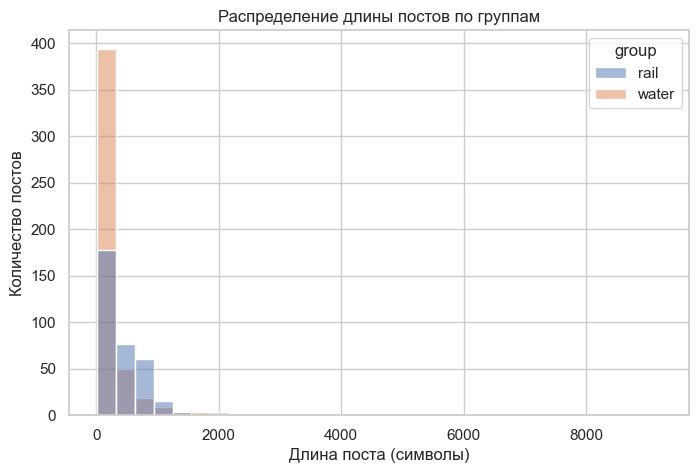

In [14]:
# Распределение длины постов по символам для двух групп
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df,
    x="text_len",
    hue="group",
    bins=30,
    kde=False,
    common_norm=False,
)
plt.xlabel("Длина поста (символы)")
plt.ylabel("Количество постов")
plt.title("Распределение длины постов по группам")
plt.show()

### 5.2. Баланс классов

Смотрим, сколько постов относится к каждой тематике (*rail* и *water*),  
и проверяем, нет ли сильного дисбаланса.

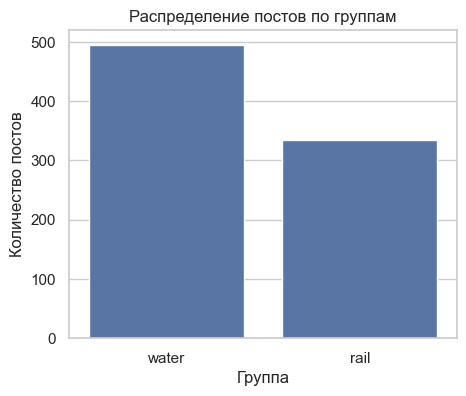

In [15]:
group_counts = df["group"].value_counts().reset_index()
group_counts.columns = ["group", "count"]
group_counts

plt.figure(figsize=(5, 4))
sns.barplot(data=group_counts, x="group", y="count")
plt.xlabel("Группа")
plt.ylabel("Количество постов")
plt.title("Распределение постов по группам")
plt.show()

### 5.3. Частотный словарь лемм по группам

Для каждого класса считаем топ-20 наиболее частотных лемм  
и визуализируем их. Это позволяет увидеть, какая лексика  
характерна для железнодорожной и водной тематик.

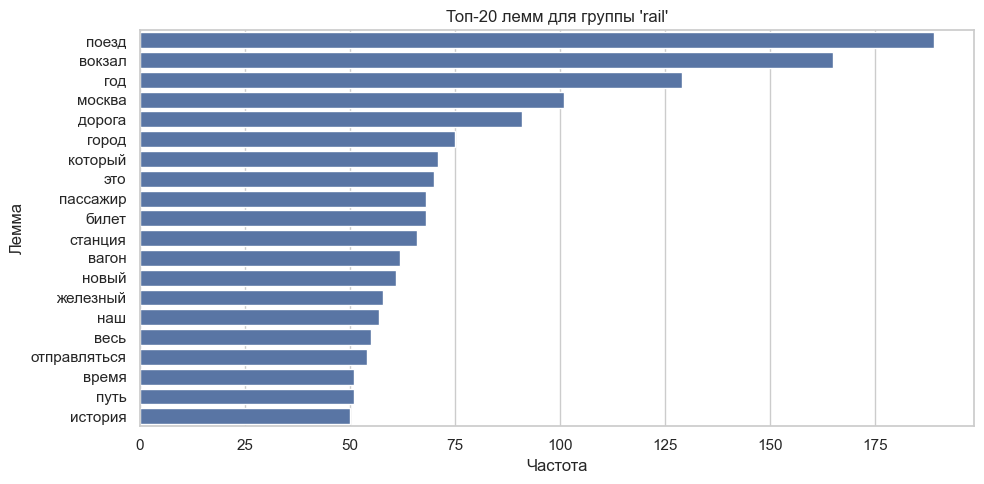

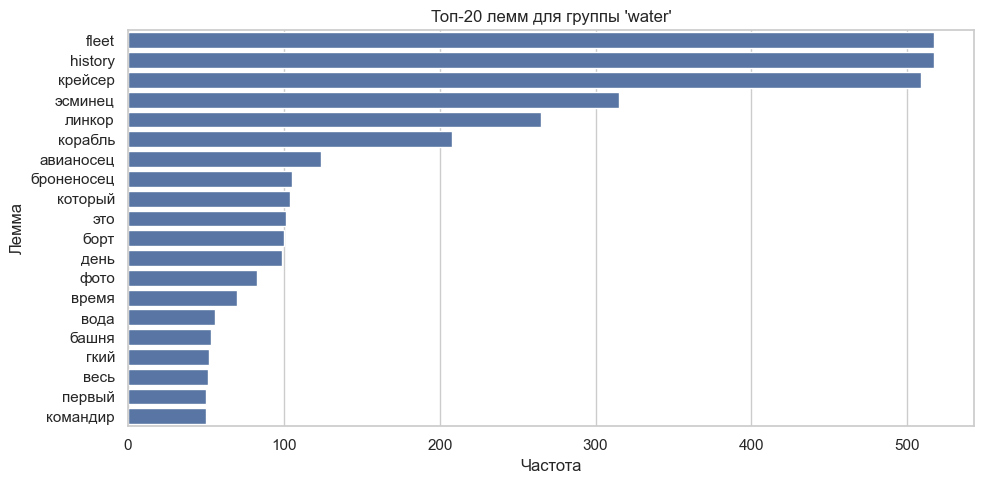

In [16]:
def get_top_lemmas(df_subset, n_top=20):
    """
    Считает топ-n лемм в подтаблице с колонкой text_norm.
    """
    counter = Counter()
    for text in df_subset["text_norm"]:
        if not isinstance(text, str):
            continue
        tokens = text.split()
        counter.update(tokens)
    return counter.most_common(n_top)

# Топ лемм для ж/д группы
top_rail = get_top_lemmas(df[df["group"] == "rail"], n_top=20)
top_water = get_top_lemmas(df[df["group"] == "water"], n_top=20)

top_rail_df = pd.DataFrame(top_rail, columns=["lemma", "freq"])
top_water_df = pd.DataFrame(top_water, columns=["lemma", "freq"])

plt.figure(figsize=(10, 5))
sns.barplot(data=top_rail_df, x="freq", y="lemma")
plt.xlabel("Частота")
plt.ylabel("Лемма")
plt.title("Топ-20 лемм для группы 'rail'")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=top_water_df, x="freq", y="lemma")
plt.xlabel("Частота")
plt.ylabel("Лемма")
plt.title("Топ-20 лемм для группы 'water'")
plt.tight_layout()
plt.show()

## 6. Подготовка данных для обучения моделей

### 6.1. Разделение на обучающую и тестовую выборки

Разделяем корпус нормализованных текстов и меток классов  
на обучающую и тестовую части (80/20)  
с сохранением пропорций классов (`stratify=y`).

In [ ]:
# Признаки — нормализованный текст, целевая переменная — target (0 = rail, 1 = water)
X = df["text_norm"]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       
    random_state=42,
    stratify=y            # сохраняем пропорции классов
)

print("Размер train:", X_train.shape[0])
print("Размер test:", X_test.shape[0])
print("\nРаспределение классов в train:")
print(y_train.value_counts())
print("\nРаспределение классов в test:")
print(y_test.value_counts())

Размер train: 663
Размер test: 166

Распределение классов в train:
target
1    396
0    267
Name: count, dtype: int64

Распределение классов в test:
target
1    99
0    67
Name: count, dtype: int64


### 6.2. Векторизация текстов методом TF-IDF

Строим числовое представление текстов с помощью `TfidfVectorizer`.  
Используем униграммы и биграммы, ограничиваем размер словаря  
и отбрасываем слишком редкие термы.  

Полученные матрицы `X_train_tfidf` и `X_test_tfidf`  
подаются на вход моделям классификации.

In [18]:
# Настраиваем TF-IDF векторизатор
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),    # униграммы и биграммы
    max_features=20000,    # ограничиваем размер словаря
    min_df=5               # игнорируем очень редкие слова (меньше 5 документов)
)

# Обучаем векторизатор на обучающей выборке и трансформируем train/test
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)

TF-IDF train shape: (663, 994)
TF-IDF test shape: (166, 994)


## 7. Обучение и оценка моделей классификации

### 7.1. Модель Multinomial Naive Bayes

Обучаем мультиномиальный наивный Байес на TF-IDF-признаках  
обучающей выборки и оцениваем качество на тесте.  

Считаем accuracy и F1-мера по классам,  
а также строим матрицу ошибок.

In [19]:
# Обучаем базовую модель
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)

# Предсказания на тесте
y_pred_nb = nb_clf.predict(X_test_tfidf)

# Метрики
acc_nb = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy (Naive Bayes): {acc_nb:.3f}\n")

print("Отчёт по классам (Naive Bayes):")
print(classification_report(y_test, y_pred_nb, target_names=["rail", "water"]))

Accuracy (Naive Bayes): 0.994

Отчёт по классам (Naive Bayes):
              precision    recall  f1-score   support

        rail       1.00      0.99      0.99        67
       water       0.99      1.00      0.99        99

    accuracy                           0.99       166
   macro avg       0.99      0.99      0.99       166
weighted avg       0.99      0.99      0.99       166



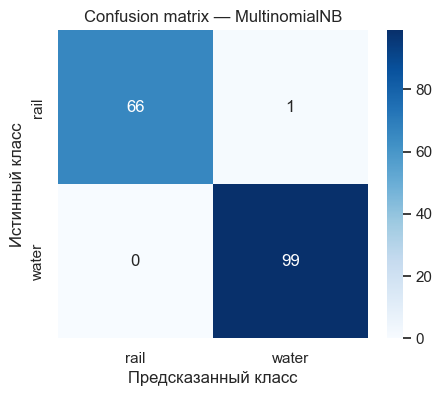

In [20]:
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_nb,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["rail", "water"],
    yticklabels=["rail", "water"]
)
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Confusion matrix — MultinomialNB")
plt.show()

### 7.2. Модель логистической регрессии

Обучаем логистическую регрессию на тех же TF-IDF-признаках.  
Сравниваем метрики с наивным Байесом и строим матрицу ошибок.  

Дополнительно используем веса логистической регрессии  
для интерпретации наиболее информативных признаков.

In [21]:
# Логистическая регрессия для бинарной классификации текстов
logreg_clf = LogisticRegression(
    max_iter=1000,   # побольше итераций, чтобы точно сошлось
    n_jobs=-1,       # использовать все ядра
)

logreg_clf.fit(X_train_tfidf, y_train)

y_pred_lr = logreg_clf.predict(X_test_tfidf)

acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy (Logistic Regression): {acc_lr:.3f}\n")

print("Отчёт по классам (Logistic Regression):")
print(classification_report(y_test, y_pred_lr, target_names=["rail", "water"]))

Accuracy (Logistic Regression): 0.994

Отчёт по классам (Logistic Regression):
              precision    recall  f1-score   support

        rail       0.99      1.00      0.99        67
       water       1.00      0.99      0.99        99

    accuracy                           0.99       166
   macro avg       0.99      0.99      0.99       166
weighted avg       0.99      0.99      0.99       166



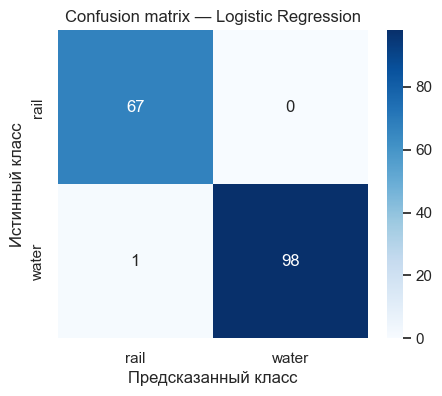

In [22]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_lr,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["rail", "water"],
    yticklabels=["rail", "water"]
)
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Confusion matrix — Logistic Regression")
plt.show()

## 8. Интерпретация признаков

На основе коэффициентов логистической регрессии  
выделяем термы и биграммы, которые сильнее всего  
ассоциированы с каждым классом.

Отдельно смотрим топ-термы для железнодорожной тематики (*rail*)  
и для водного транспорта (*water*) и анализируем,  
какие слова и выражения чаще всего «тянут» решение модели  
в сторону соответствующего класса.

In [23]:
# Получаем список признаков (слов/н-грамм) из TF-IDF
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Коэффициенты логистической регрессии
# У нас бинарная классификация, поэтому coef_ имеет форму (1, n_features)
coefs = logreg_clf.coef_[0]

# Сортируем индексы по убыванию веса
top_positive_indices = np.argsort(coefs)[-20:]   # топ-20 признаков для класса "water" (target=1)
top_negative_indices = np.argsort(coefs)[:20]    # топ-20 признаков для класса "rail"  (target=0)

print("Топ-20 признаков для класса 'rail' (target=0):")
for idx in top_negative_indices:
    print(f"{feature_names[idx]:<25} {coefs[idx]:.3f}")

print("\nТоп-20 признаков для класса 'water' (target=1):")
for idx in top_positive_indices:
    print(f"{feature_names[idx]:<25} {coefs[idx]:.3f}")

Топ-20 признаков для класса 'rail' (target=0):
вокзал                    -1.887
поезд                     -1.652
станция                   -0.974
дорога                    -0.950
москва                    -0.935
город                     -0.899
отправляться              -0.840
наш                       -0.783
год                       -0.769
поездка                   -0.729
билет                     -0.727
пейзаж                    -0.710
путешествие               -0.706
железный дорога           -0.637
выходной                  -0.633
история                   -0.623
heart                     -0.623
вагон                     -0.609
путь                      -0.597
красивый                  -0.594

Топ-20 признаков для класса 'water' (target=1):
тип                       0.658
вода                      0.662
верфь                     0.703
башня                     0.719
борт                      0.764
фото                      0.889
броненосец fleet          0.895
авианосец fleet     

## 9. Демонстрация работы модели на произвольных примерах

Определяем вспомогательные функции:

- `preprocess_single_text` — полный цикл предобработки одного текста  
  (очистка, нормализация);
- `classify` — применение обученной модели к произвольной строке:  
  вывод исходного и нормализованного текста, предсказанной группы  
  и, при необходимости, вероятностей по классам.

In [24]:
# Словарь для обратного преобразования класса в название группы
inv_label_mapping = {0: "rail", 1: "water"}


def preprocess_single_text(raw_text: str) -> str:
    """
    Полный цикл предобработки для одного текста:
    - базовая очистка (clean_text)
    - нормализация (normalize_text)
    Возвращает нормализованную строку.
    """
    cleaned = clean_text(raw_text)
    normalized = normalize_text(cleaned)
    return normalized


def classify(text: str, model=logreg_clf, vectorizer=tfidf_vectorizer):
    """
    Классификация одного текста:
    - предобработка
    - преобразование в TF-IDF
    - предсказание класса и вероятностей
    """
    # предобработка
    norm_text = preprocess_single_text(text)
    
    if not norm_text.strip():
        print("После предобработки текст пуст — модель не может его классифицировать.")
        return None

    # преобразуем в вектор
    X_vec = vectorizer.transform([norm_text])

    # предсказание класса
    y_pred = model.predict(X_vec)[0]

    # если модель умеет вероятности — покажем их
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_vec)[0]
        proba_dict = {
            inv_label_mapping[cls]: float(p) for cls, p in zip(model.classes_, proba)
        }
    else:
        proba_dict = None

    result = {
        "raw_text": text,
        "normalized_text": norm_text,
        "predicted_class": int(y_pred),
        "predicted_group": inv_label_mapping[int(y_pred)],
        "probabilities": proba_dict,
    }

    # Красивый вывод
    print("Исходный текст:")
    print(text)
    print("\nНормализованный текст:")
    print(norm_text)
    print("\nПредсказанная группа:", result["predicted_group"])
    if proba_dict is not None:
        print("Вероятности по классам:")
        for g, p in proba_dict.items():
            print(f"  {g}: {p:.3f}")

    return result


### 9.1. Примеры классификации тестовых предложений

Проверяем работу финальной модели на нескольких  
руками составленных примерах для железнодорожной  
и водной тематик.

In [25]:
examples = [
    "Новый скорый поезд отправится из Москвы в Санкт-Петербург по обновлённому расписанию.",
    "Сегодня на реке открылась навигация, первый теплоход уже отправился в рейс.",
    "Продажа билетов на международные поезда временно приостановлена.",
    "Суда на подводных крыльях будут ходить чаще в летний сезон.",
]

for txt in examples:
    print("=" * 80)
    classify(txt)
    print()

Исходный текст:
Новый скорый поезд отправится из Москвы в Санкт-Петербург по обновлённому расписанию.

Нормализованный текст:
новый скорый поезд отправиться москва санкт петербург обновть нном расписание

Предсказанная группа: rail
Вероятности по классам:
  rail: 0.872
  water: 0.128

Исходный текст:
Сегодня на реке открылась навигация, первый теплоход уже отправился в рейс.

Нормализованный текст:
сегодня река открыться навигация первый теплоход отправиться рейс

Предсказанная группа: rail
Вероятности по классам:
  rail: 0.770
  water: 0.230

Исходный текст:
Продажа билетов на международные поезда временно приостановлена.

Нормализованный текст:
продажа билет международный поезд временно приостановить

Предсказанная группа: rail
Вероятности по классам:
  rail: 0.867
  water: 0.133

Исходный текст:
Суда на подводных крыльях будут ходить чаще в летний сезон.

Нормализованный текст:
суд подводный крыло ходить частый летний сезон

Предсказанная группа: rail
Вероятности по классам:
  rail:

---

## 10. Выводы по результатам экспериментов

Обе использованные модели (Multinomial Naive Bayes и логистическая регрессия)  
показали практически идеальное качество на тестовой выборке:  
accuracy и F1-мера близки к 1.0, а матрицы ошибок не содержат неверных классификаций.  

Это означает, что выбранные тематические сообщества хорошо различаются  
по лексике, а простого конвейера предобработки + TF-IDF + линейная модель  
достаточно для успешной классификации постов по двум видам транспорта.